In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv("../data/processed/thiroid_cancer_processed.csv")

In [3]:
df.head(1)

,Age,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,...,Ethnicity_Middle Eastern,Country_China,Country_Germany,Country_India,Country_Japan,Country_Nigeria,Country_Russia,Country_South Korea,Country_UK,Country_USA
0,66,0,1,0,0,0,0,9.37,1.67,6.16,...,0,0,0,0,0,0,1,0,0,0


In [4]:
X = df[['Age', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency',
       'Smoking', 'Obesity', 'Diabetes', 'TSH_Level', 'T3_Level', 'T4_Level',
       'Nodule_Size','Gender_Male', 'Ethnicity_Asian',
       'Ethnicity_Caucasian', 'Ethnicity_Hispanic',
       'Ethnicity_Middle Eastern','Country_China', 'Country_Germany',
       'Country_India', 'Country_Japan', 'Country_Nigeria', 'Country_Russia',
       'Country_South Korea', 'Country_UK', 'Country_USA']]
y = df["Diagnostico"]

# PYTORCH

### Escalar los datos 

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Pasar los dataframes a tensores (arrays de una dimensión)

In [6]:
# Convertir a tensores de PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

### División de los datos entre train y test

In [10]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

### Pasar a datasets de tensores para pasar de varias dimensiones a una sola

In [11]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

### Trabajar con lotes de 32 registros

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Clase de PyTorch con 5 capas:
- 1 de entrada con 25 variables
- 4 ocultas aplicando RELU
- 1 de salida aplicando signoide para aplanar el resultado entre 0 y 1

In [13]:
# Definir la red neuronal
class TyroidNN(nn.Module):
    def __init__(self):
        super(TyroidNN, self).__init__()
        self.fc1 = nn.Linear(25, 66)
        self.fc2 = nn.Linear(66, 33)
        self.fc25 = nn.Linear(33, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc25(x))
        x = self.sigmoid(self.fc3(x))
        return x

### Aplicando el optimizador Adam y learning rate

In [14]:
# Instanciar modelo, función de pérdida y optimizador
model = TyroidNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Ejecutar la red neuronal con 300 epocas

In [15]:
def train_model(model, train_loader, criterion, optimizer, epochs=300):
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch 0, Loss: 0.3111
Epoch 10, Loss: 0.0235
Epoch 20, Loss: 0.1184
Epoch 30, Loss: 0.0295
Epoch 40, Loss: 0.2814
Epoch 50, Loss: 0.0664
Epoch 60, Loss: 0.2598
Epoch 70, Loss: 0.2043
Epoch 80, Loss: 0.1135
Epoch 90, Loss: 0.0516
Epoch 100, Loss: 0.0335
Epoch 110, Loss: 0.0966
Epoch 120, Loss: 0.1562
Epoch 130, Loss: 0.0262
Epoch 140, Loss: 0.1921
Epoch 150, Loss: 0.1261
Epoch 160, Loss: 0.1206
Epoch 170, Loss: 0.1236
Epoch 180, Loss: 0.0353
Epoch 190, Loss: 0.4112
Epoch 200, Loss: 0.1247
Epoch 210, Loss: 0.0731
Epoch 220, Loss: 0.2015
Epoch 230, Loss: 0.1179
Epoch 240, Loss: 0.1039
Epoch 250, Loss: 0.0479
Epoch 260, Loss: 0.0653
Epoch 270, Loss: 0.0243
Epoch 280, Loss: 0.1264
Epoch 290, Loss: 0.0395


### Mostrar la matriz de confusión de la red neuronal

Accuracy: 0.8149


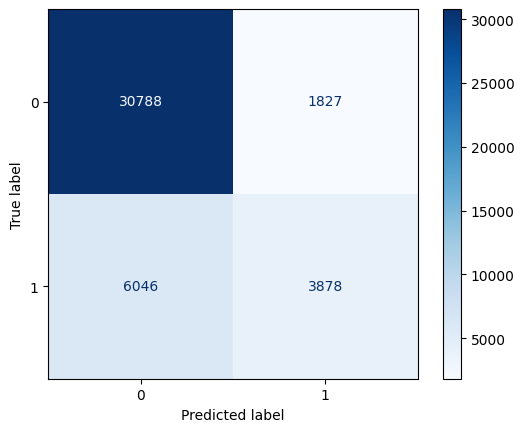

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calcular accuracy (opcional)
    accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
    print(f'Accuracy: {accuracy:.4f}')

    return np.array(all_targets), np.array(all_preds)


# Evaluar y obtener etiquetas
y_true, y_pred = evaluate_model(model, test_loader)

# Mostrar matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")


### Muestra de las distintas métricas tanto en diagnóstico de cáncer como en el que no tiene cáncer:
- Precision: muestra cuantas de nuestras predicciones positivas son correctas
- recal:  mide de los positivos cuántos son realmente positivos
- f1-score: es la media entre precision y recal
- support: son el número de registro de cada clase en test


In [20]:
# Evaluar el modelo (como hiciste antes)
y_true, y_pred = evaluate_model(model, test_loader)

# Mostrar clasificación detallada
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=["No Cáncer", "Cáncer"]))


Accuracy: 0.8149

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Cáncer       0.84      0.94      0.89     32615
      Cáncer       0.68      0.39      0.50      9924

    accuracy                           0.81     42539
   macro avg       0.76      0.67      0.69     42539
weighted avg       0.80      0.81      0.80     42539



### Evaluar el modelo para sacar el accuracy

In [14]:
def evaluate_model(model, test_loader):
    model.eval()  # Cambia el modelo a modo de evaluación
    correct, total = 0, 0
    all_outputs = []

    with torch.no_grad():  # No calcular gradientes durante la evaluación
        for inputs, targets in test_loader:
            outputs = model(inputs)  # Realizar la predicción
            predicted = (outputs > 0.5).float()  # MA-NI-PU-LA-BLE!

            all_outputs.append(outputs.cpu().numpy())  # Convertir a numpy para almacenar fácilmente

            # Mostrar outputs y predicciones
            print("Outputs:", outputs)
            print("Predicted:", predicted)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Convertir la lista de outputs a un solo arreglo de numpy
    all_outputs = np.concatenate(all_outputs, axis=0)

    print(f'Accuracy: {correct / total:.4f}')
    return all_outputs  # Devolver todos los outputs almacenados

all_test_outputs = evaluate_model(model, test_loader)

Outputs: tensor([[0.1538],
        [0.7469],
        [0.1262],
        [0.1433],
        [0.1385],
        [0.1787],
        [0.1098],
        [0.6339],
        [0.5643],
        [0.1692],
        [0.1339],
        [0.3265],
        [0.1330],
        [0.1882],
        [0.1453],
        [0.0996],
        [0.1524],
        [0.1598],
        [0.1511],
        [0.1494],
        [0.1666],
        [0.1817],
        [0.8014],
        [0.1135],
        [0.2317],
        [0.2030],
        [0.1072],
        [0.1701],
        [0.1528],
        [0.7368],
        [0.1708],
        [0.2133]])
Predicted: tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.

# RED NEUROAL UTILIZANDO CLASE DE SCIKIT LEARN

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
modelo_1 = MLPClassifier(
                hidden_layer_sizes=(50),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 2517,
                early_stopping=True
            )

# modelo_2 = MLPClassifier(
#                 hidden_layer_sizes=(60),
#                 learning_rate_init=0.01,
#                 solver = 'lbfgs',
#                 max_iter = 1000,
#                 random_state = 2517,
#                 early_stopping=True,
#             )

# modelo_3 = MLPClassifier(
#                 hidden_layer_sizes=(60, 30),
#                 learning_rate_init=0.01,
#                 solver = 'lbfgs',
#                 max_iter = 5000,
#                 random_state = 2517,
#                 early_stopping=True
#             )

# modelo_4 = MLPClassifier(
#                 hidden_layer_sizes=(70, 50, 30),
#                 learning_rate_init=0.01,
#                 solver = 'lbfgs',
#                 max_iter = 5000,
#                 random_state = 2517,
#                 early_stopping=True
#             )

# modelo_1.fit(X=X, y=y)
modelo_1.fit(X=X, y=y)
# modelo_3.fit(X=X, y=y)
# modelo_4.fit(X=X, y=y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=50,
              learning_rate_init=0.01, max_iter=1000, random_state=2517,
              solver='lbfgs')

In [24]:
print(accuracy_score(y_test,modelo_1.predict(X_test)))

0.824776680771039


In [25]:
param_grid = {'hidden_layer_sizes':[10, 15, 25, 50]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        learning_rate_init=0.01,
                        solver = 'lbfgs',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 2517
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

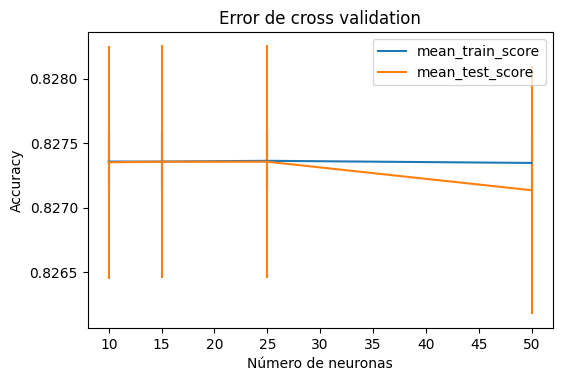

In [26]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Número de neuronas')
ax.set_title('Error de cross validation');

In [34]:
param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init': [0.001, 0.01, 0.1],
}

grid = GridSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 2000, random_state=2517),
        param_grid=  param_distributions,
        scoring    = 'accuracy',
        cv         = 3,
        return_train_score = True
       )

grid.fit(X = X, y = y)

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,mean_test_score,std_test_score,mean_train_score,std_train_score
29,1.000,10,0.100,0.827360,0.000561,0.827358,0.000282
28,1.000,10,0.010,0.827360,0.000561,0.827358,0.000282
27,1.000,10,0.001,0.827360,0.000561,0.827358,0.000282
0,0.001,10,0.001,0.827355,0.000562,0.827358,0.000284
49,100.000,"(10, 10)",0.010,0.827355,0.000562,0.827355,0.000281
36,10.000,10,0.001,0.827355,0.000562,0.827350,0.000280
37,10.000,10,0.010,0.827355,0.000562,0.827350,0.000280
38,10.000,10,0.100,0.827355,0.000562,0.827350,0.000280
45,100.000,10,0.001,0.827355,0.000562,0.827355,0.000281
46,100.000,10,0.010,0.827355,0.000562,0.827355,0.000281
